In [1]:
import pymc as pm
import pytensor.tensor as pt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# Load data
df = pd.read_csv('MMM_test_data.csv')
df['start_of_week'] = pd.to_datetime(df['start_of_week'], format='%d-%m-%y')

spend_cols = df.filter(like='spend').columns.tolist()
n_channels = len(spend_cols)

# Time features for seasonality
df['week_of_year'] = df['start_of_week'].dt.isocalendar().week
n_weeks = len(df)

# Time index for linear trend 
time_idx = np.arange(n_weeks, dtype='float32')

# Prepare data tensors
spend_data = df[spend_cols].values.astype('float32')
revenue_data = df['revenue'].values.astype('float32')
week_of_year = df['week_of_year'].values.astype('int32')

def geometric_adstock(spend_series, alpha, l_max):
    # Calculate retention weights
    weights = alpha ** pt.arange(l_max, dtype='float32')
    weights /= pt.sum(weights)
    
    # Pad the spend series with zeros for lookback
    padded = pt.concatenate([pt.zeros(l_max-1, dtype='float32'), spend_series])
    
    # Create indices for all time steps
    time_steps = spend_series.shape[0]
    t = pt.arange(time_steps)
    
    # Create a matrix of all windows at once
    windows = padded[t[:, None] + pt.arange(l_max)]
    
    # Reverse each window and multiply by weights
    adstock = pt.sum(windows[:, ::-1] * weights, axis=1)
    
    return adstock

with pm.Model() as mmm:
    # Priors
    base = pm.Normal('base', mu=revenue_data.mean(), sigma=10)  # Base
    beta = pm.HalfNormal('beta', sigma=10, shape=n_channels)  # Effectiveness
    alpha = pm.Beta('alpha', alpha=2, beta=2, shape=n_channels)  # Adstock retention
    trend_slope = pm.Normal('trend_slope', mu=0, sigma=10)
    trend = pm.Deterministic('trend', trend_slope * time_idx)

    # Seasonal frequencies
    beta_sin1 = pm.Normal('beta_sin1', mu=0, sigma=1)
    beta_cos1 = pm.Normal('beta_cos1', mu=0, sigma=1)
    beta_sin2 = pm.Normal('beta_sin2', mu=0, sigma=1)
    beta_cos2 = pm.Normal('beta_cos2', mu=0, sigma=1)

    freq1 = 2 * np.pi / 52  # Annual
    freq2 = 2 * np.pi / 26  # Semi-annual

    seasonality = (beta_sin1 * pt.sin(freq1 * week_of_year) + 
        beta_cos1 * pt.cos(freq1 * week_of_year) +
        beta_sin2 * pt.sin(freq2 * week_of_year) + 
        beta_cos2 * pt.cos(freq2 * week_of_year))
    
    # Adstock transformation
    adstocked = pt.stack([
        geometric_adstock(spend_data[:, i], alpha[i], l_max=8)
        for i in range(n_channels)
    ], axis=1)
    
    media_contribution = pt.dot(adstocked, beta)

	# Main equation
    mu = base + media_contribution + trend + seasonality
    sigma = pm.HalfNormal('sigma', sigma=1)  # Noise

    pm.Normal('revenue', mu=mu, sigma=sigma, observed=revenue_data)
    
    # Sample
    trace = pm.sample(
        draws=4000,
        tune=2000,
        cores=4,
        target_accept=0.95,
        idata_kwargs={'log_likelihood': True}
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [base, beta, alpha, trend_slope, beta_sin1, beta_cos1, beta_sin2, beta_cos2, sigma]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 88 seconds.


/home/emre/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (125), generating only 20 plots
  warnings.warn(


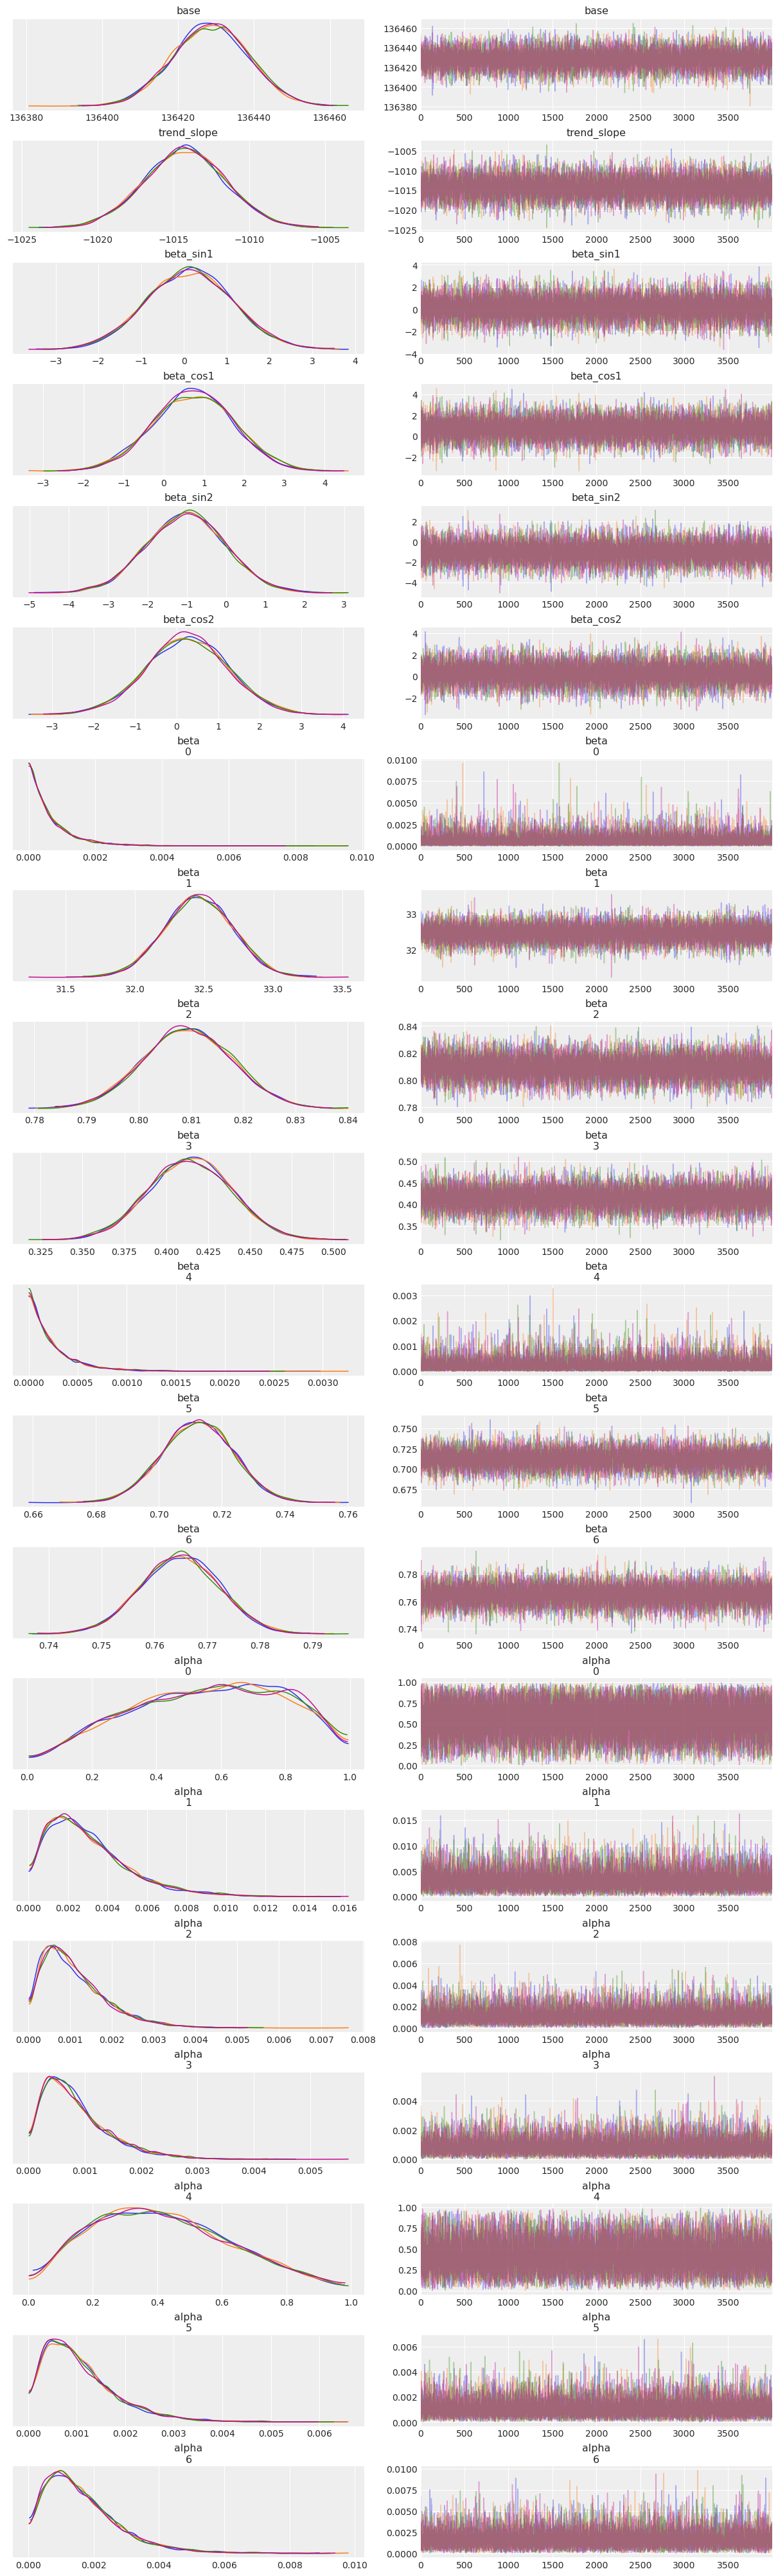

In [3]:
az.style.use("arviz-darkgrid")
az.plot_trace(trace, compact=False);

In [4]:
with mmm:
    prior_samples = pm.sample_prior_predictive(samples=1000, var_names=['beta'])

prior_means = np.mean(prior_samples.prior['beta'].values.reshape(-1, n_channels), axis=0)
posterior_means = np.mean(trace.posterior['beta'].values.reshape(-1, n_channels), axis=0)

print("Channel  Prior Mean  Posterior Mean")
print("----------------------------------")
for i in range(n_channels):
    print(f"{i+1:^8} {prior_means[i]:.5f} {posterior_means[i]:.5f}")

Sampling: [beta]


Channel  Prior Mean  Posterior Mean
----------------------------------
   1     7.94153 0.00067
   2     8.00845 32.45902
   3     8.21624 0.80938
   4     8.11829 0.41430
   5     7.90422 0.00025
   6     7.98609 0.71230
   7     7.98457 0.76487


Sampling: [revenue]


Output()


Revenue Prediction Performance:
----------------------------------
MAPE: 20.06%
R²: 0.4290


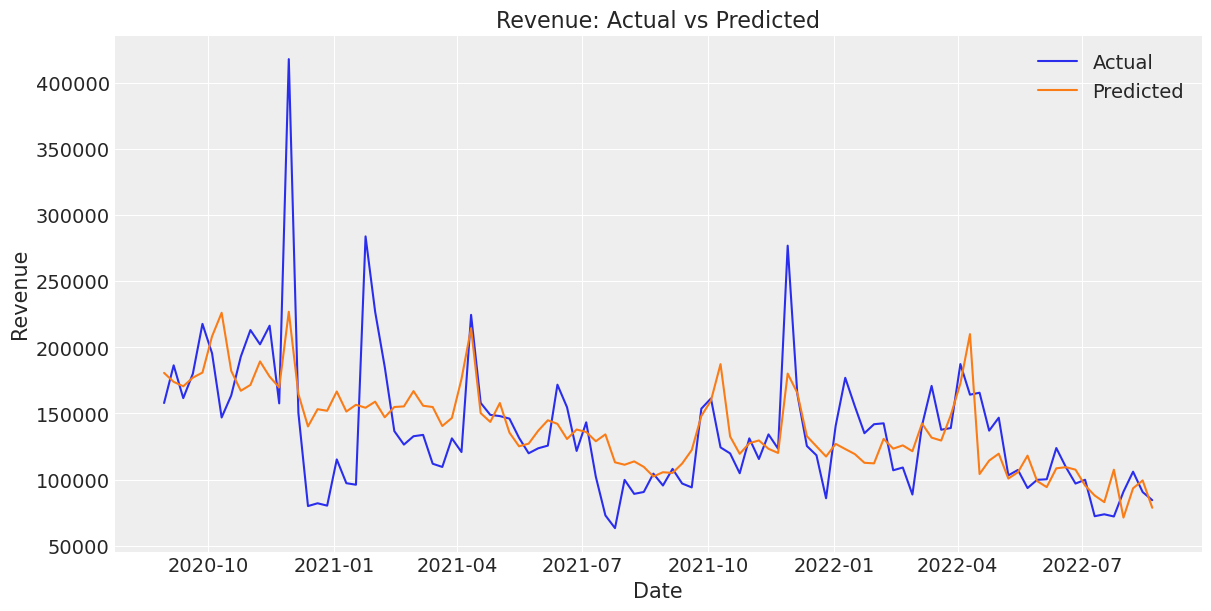

In [5]:
with mmm:
    ppc = pm.sample_posterior_predictive(trace, var_names=['revenue'])

posterior_revenue = ppc.posterior_predictive['revenue'].values.reshape(-1, len(df))

y_true = df['revenue'].values
y_pred = np.mean(posterior_revenue, axis=0)

# MAPE
mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100

# R^2
ss_res = np.sum((y_true - y_pred)**2)  # Residual sum of squares
ss_tot = np.sum((y_true - np.mean(y_true))**2)  # Total sum of squares
r2 = 1 - (ss_res/ss_tot)

print("\nRevenue Prediction Performance:")
print("----------------------------------")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

# Optional: Basic plot
plt.figure(figsize=(12,6))
plt.plot(df['start_of_week'], y_true, label='Actual')
plt.plot(df['start_of_week'], y_pred, label='Predicted')
plt.legend()
plt.title("Revenue: Actual vs Predicted")
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.show()

In [21]:
channel_spend = df[spend_cols].mean().values

# ROI = (Effect / Spend) * 100
roi_pct = (posterior_means / channel_spend) * 100

print("Channel   Spend    Effect    ROI(%)")
print("----------------------------------------")
for i in range(n_channels):
    print(f"{i+1:^7} ${channel_spend[i]:.2f}   {posterior_means[i]:.4f}   {roi_pct[i]:>.4f}%")

Channel   Spend    Effect    ROI(%)
----------------------------------------
   1    $1245.60   0.0007   0.0001%
   2    $343.64   32.4590   9.4456%
   3    $19507.18   0.8094   0.0041%
   4    $6915.14   0.4143   0.0060%
   5    $8575.61   0.0002   0.0000%
   6    $5063.70   0.7123   0.0141%
   7    $27701.37   0.7649   0.0028%
